In [2]:
# =====================================================================
#  BOOSTING — NOTEBOOK VERSION (ONE BLOCK)
# =====================================================================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error


# =====================================================================
# 1. LOAD DATA
# =====================================================================

DATA_PATH = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics/data/databasecsv.csv")

def load_data(path=DATA_PATH):
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path.resolve()}")
    df = pd.read_csv(path, sep=";")
    df.columns = df.columns.str.strip()
    return df

df = load_data()
print("Loaded:", df.shape)


# =====================================================================
# 2. FEATURE ENGINEERING (LAGS + DIFF + TREND + FE)
# =====================================================================

def engineer_features(df):

    df["canton_id"] = df["canton"].astype("category").cat.codes
    df = df.sort_values(["canton_id", "year"]).copy()

    # 1) Lag
    df["migration_lag1"] = df.groupby("canton_id")["migration_rate"].shift(1)

    # 2) Differences
    for col in ["log_rent_avg", "log_avg_income", "log_unemployment", "log_schockexposure"]:
        df[f"d_{col}"] = df.groupby("canton_id")[col].diff()

    # 3) Trend
    df["t"] = df["year"] - df["year"].min()

    # 4) FE
    FE = pd.get_dummies(df["canton_id"], prefix="FE", drop_first=True)
    df = pd.concat([df, FE], axis=1)

    return df

df = engineer_features(df)
print("After engineering:", df.shape)


# =====================================================================
# 3. PREPARE FINAL FEATURES
# =====================================================================

def prepare_dataframe(df):

    base_features = [
        "log_rent_avg",
        "log_avg_income",
        "log_unemployment",
        "log_schockexposure",
        "migration_lag1",
        "d_log_rent_avg",
        "d_log_avg_income",
        "d_log_unemployment",
        "d_log_schockexposure",
        "t",
    ]

    fe_cols = [c for c in df.columns if c.startswith("FE_")]

    feature_cols = base_features + fe_cols
    target_col = "migration_rate"

    df_clean = df.dropna(subset=feature_cols + [target_col]).copy()
    return df_clean, feature_cols, target_col

df, feature_cols, target_col = prepare_dataframe(df)
print("After clean:", df.shape)


# =====================================================================
# 4. TIME SPLIT (80/20 by years)
# =====================================================================

def time_split(df, feature_cols, target_col):

    df = df.sort_values("year")

    years = df["year"].unique()
    cut = int(0.8 * len(years))

    train_years = years[:cut]
    test_years  = years[cut:]

    df_train = df[df["year"].isin(train_years)]
    df_test  = df[df["year"].isin(test_years)]

    X_train = df_train[feature_cols].to_numpy()
    X_test  = df_test[feature_cols].to_numpy()

    y_train = df_train[target_col].to_numpy()
    y_test  = df_test[target_col].to_numpy()

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = time_split(df, feature_cols, target_col)

print("Train:", X_train.shape, "Test:", X_test.shape)


# =====================================================================
# 5. TRAIN GRADIENT BOOSTING
# =====================================================================

def train_boosting(X_train, y_train):
    
    model = GradientBoostingRegressor(
        loss="squared_error",
        n_estimators=80,       # SAME AS YOUR SCRIPT
        learning_rate=0.05,
        max_depth=2,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=0,
    )

    model.fit(X_train, y_train)
    return model

model = train_boosting(X_train, y_train)


# =====================================================================
# 6. EVALUATION
# =====================================================================

def evaluate(model, X_train, y_train, X_test, y_test):

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2  = r2_score(y_test, y_pred_test)
    rmse     = np.sqrt(mean_squared_error(y_test, y_pred_test))

    return y_pred_test, train_r2, test_r2, rmse

y_pred_test, train_r2, test_r2, rmse = evaluate(model, X_train, y_train, X_test, y_test)


print("\n=== RESULTS ===")
print(f"Train R² : {train_r2:.4f}")
print(f"Test  R² : {test_r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")


# =====================================================================
# 7. FEATURE IMPORTANCE
# =====================================================================

importance = dict(zip(feature_cols, model.feature_importances_))

print("\n=== FEATURE IMPORTANCE ===")
for k, v in sorted(importance.items(), key=lambda x: -x[1]):
    print(f"{k:30s}: {v:.4f}")


Loaded: (285, 38)
After engineering: (285, 71)
After clean: (234, 71)
Train: (182, 36) Test: (52, 36)

=== RESULTS ===
Train R² : 0.7952
Test  R² : 0.7031
Test RMSE: 0.1768

=== FEATURE IMPORTANCE ===
migration_lag1                : 0.6670
log_unemployment              : 0.1179
FE_5                          : 0.1029
log_rent_avg                  : 0.0382
t                             : 0.0181
FE_12                         : 0.0136
log_avg_income                : 0.0121
d_log_rent_avg                : 0.0093
log_schockexposure            : 0.0077
d_log_unemployment            : 0.0059
FE_13                         : 0.0033
FE_6                          : 0.0027
FE_1                          : 0.0013
d_log_avg_income              : 0.0000
d_log_schockexposure          : 0.0000
FE_0                          : 0.0000
FE_2                          : 0.0000
FE_3                          : 0.0000
FE_4                          : 0.0000
FE_7                          : 0.0000
FE_8               

Train R² : 0.7952321221205707
Test  R² : 0.7030715005485066
RMSE     : 0.17677958529740323


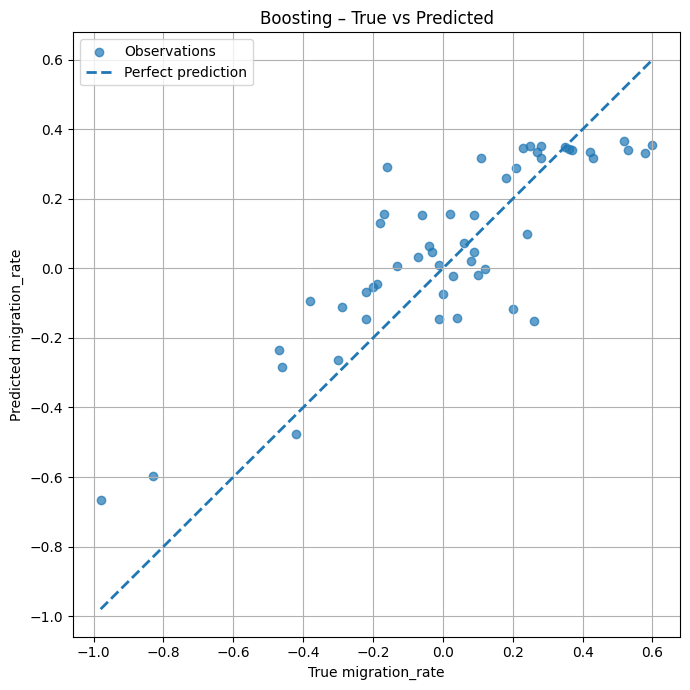

In [4]:
import sys
from pathlib import Path
ROOT = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics")
sys.path.append(str(ROOT))

from src.ML.Gradientboosting.gradientboosting import (
    load_data,
    engineer_features,
    prepare_dataframe,
    time_split,
    train_boosting,
    evaluate,
)
from src.ML.Gradientboosting.plotgradientboosting import plot_true_vs_pred_boost

# === Pipeline ===
df = load_data()  # lit data/databasecsv.csv par défaut
df = engineer_features(df)
df, feature_cols, target_col = prepare_dataframe(df)

X_train, X_test, y_train, y_test = time_split(df, feature_cols, target_col)
model = train_boosting(X_train, y_train)

train_r2, test_r2, rmse = evaluate(model, X_train, y_train, X_test, y_test)
print("Train R² :", train_r2)
print("Test  R² :", test_r2)
print("RMSE     :", rmse)

# Prédictions et plot
y_pred = model.predict(X_test)
plot_true_vs_pred_boost(y_test, y_pred, title="Boosting – True vs Predicted")
